In [1]:
import sys

sys.path.append("../")

import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from main import *

np.random.seed(0)  # For reproducibility

We will now show you how to employ our framework to obtain the ground state of a coupled system!

Consider two harmonic oscilators coupled by the Hooke's law. Let $X_j$ and $P_j$ the position and momentum operators of the $j$-th oscilator. The Hamiltonian is
$$ H =  P_1^2 + X_1^2 + P_2^2 + X_2^2 + ( X_1 - X_2)^2, $$
where we omit the factor $1/2$ for simplicity.

Among other methods for operator arithmetic, such as `addition`, `pow`, and `s_prod`, we have implemented the method `distance` on our operators to compute $|X_1 - X_2|$ returning an operator of the same kind.

We define a number of qubits for each system, and the total number of qubits will be the sum of them.

In [2]:
num_wires = 3  # qubits per system
dev = qml.device("lightning.qubit", wires=2 * num_wires)

In [3]:
wires1 = range(num_wires)
wires2 = range(num_wires, 2 * num_wires)

X1, P1 = X_and_P_ops(wires1, x_min=-2, x_max=2)
X2, P2 = X_and_P_ops(wires2, x_min=-2, x_max=2)

H12 = [X1.pow(2), X2.pow(2), P1.pow(2), P2.pow(2), distance(X1, X2).pow(2)]
H12

[<Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[3, 4, 5]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[3, 4, 5]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2, 3, 4, 5]>]

We obtain the ground state and energy by ```numpy``` for comparisons.

In [4]:
H_matrix = tomatrix(H12)
vals, vecs = np.linalg.eigh(H_matrix)
val = vals[0]
vec = vecs[:, 0]

print("Ground energy: ", val)

Ground energy:  2.7185374442043106


And then we define the variational ansatz. We will use a variation of the Zalka-Grover-Rudolf (ZGR) ansatz, introduced by [García-Molina et. al (2022)](https://link.aps.org/doi/10.1103/PhysRevA.105.012433), which is specially suitable to encode continuous functions.

We will also take advantage of the evident symmetry of the system to use `symmetric_ansatz`, which takes a base ansatz on $N-1$ qubits and returns an ansatz in $N$ qubits with the same number of parameters as before. In this manner, we can impose symmetry $f(x) = f(-x)$, or antisymmetry $f(x) = - f(-x)$ in the encoded state, as presented in the same publication already mentioned.

The variational ansatz is then, the ZGR followed by a symmetrization layer,

(<Figure size 7200x700 with 1 Axes>, <Axes: >)

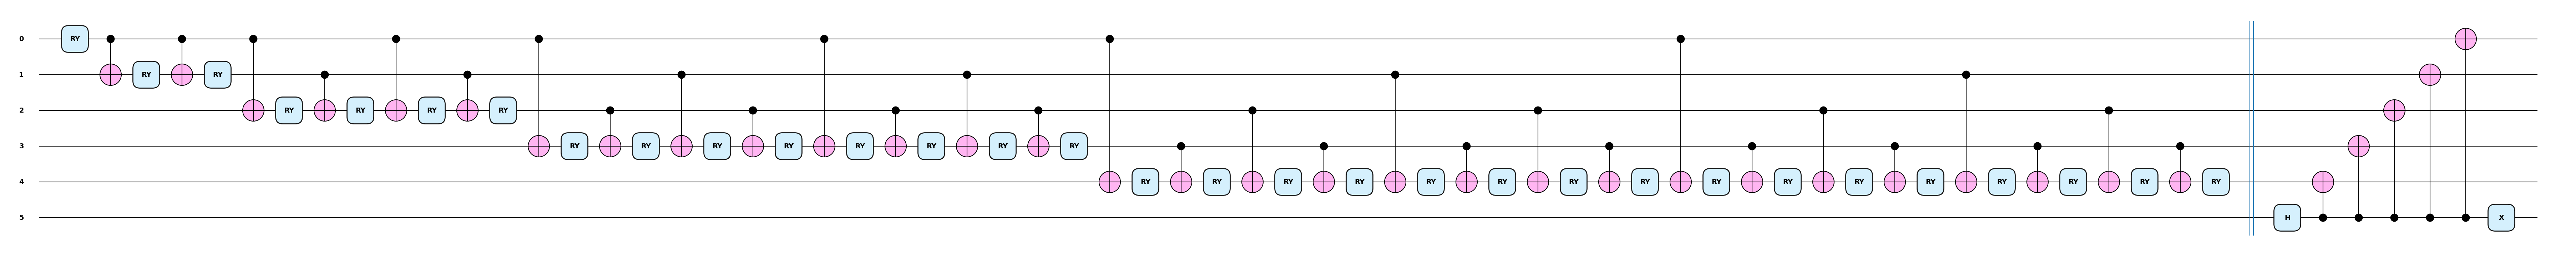

In [5]:
ansatz = ZGR_ansatz(2 * num_wires - 1)
ansatz = symmetric_ansatz(base_ansatz=ansatz)

num_params = ansatz.num_params
var_state = ansatz.construct_circuit

params = 0.01 * np.random.randn(num_params)

# Draw ansatz
qml.draw_mpl(var_state, style="pennylane")(params)

As usual, we define our `VarFourier` instance,

In [6]:
varqft = VarFourier(H12, dev, var_state)

and perform the optimization

In [7]:
Params, Energies = varqft.run(params)

Step:    230, Energy:     2.719363


We can see that the grund state was indeed achieved.

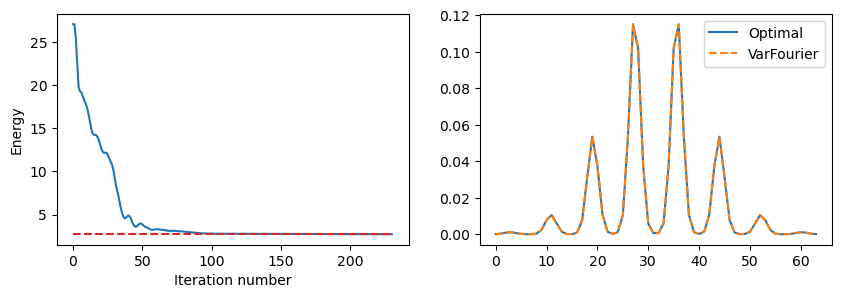

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ground_state = varqft.state(Params[-1])

ax[0].plot(Energies)
ax[0].hlines(val, 0, len(Energies), colors="tab:red", linestyles="--")
ax[0].set_xlabel("Iteration number")
ax[0].set_ylabel("Energy")

ax[1].plot(np.abs(vecs[:, 0]) ** 2)
ax[1].plot(np.abs(ground_state) ** 2, "--")
ax[1].legend(["Optimal", "VarFourier"], loc="best")

However, the state currently has the encoding of the physical space of each system mixed up. To visualize it correctly, we can
reorder it and show the probability distribution in $2$ dimensions.

Text(0.5, 0, '$x_2$')

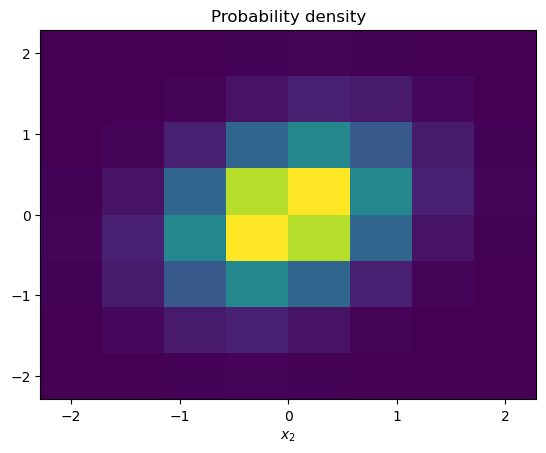

In [16]:
M = ground_state.reshape(2**num_wires, 2**num_wires)
M = np.abs(M) ** 2


plt.pcolormesh(X1.eigvals(), X2.eigvals(), M)
plt.title("Probability density")
plt.xlabel("$x_1$")
plt.xlabel("$x_2$")